# Eigenfaces

In [1]:
# Imports
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [2]:
# Styles
import matplotlib
matplotlib.rc('font', size=12)
# matplotlib.rc('lines', lw=1.5, markersize=4)
cm = plt.cm.tab10  # Colormap

import seaborn
seaborn.set_style('white')

In [3]:
import warnings
warnings.filterwarnings('ignore')

# %config InlineBackend.figure_formats = ['pdf']
# %config Completer.use_jedi = False

---

## Данные

### Исходные данные

Воспользуемся набором данных `fetch_olivetti_faces` из пакета `sklearn`.
В наборе 400 фотографий размером 64 на 64 &mdash; это портреты 40 людей в 10 ракурсах каждый.

In [4]:
from sklearn.datasets import fetch_olivetti_faces
data = fetch_olivetti_faces()
Imgs = data.images
print(Imgs.shape)
fW, fH = Imgs.shape[1], Imgs.shape[2]

(400, 64, 64)


Объединим все портреты в единую матрицу.
Для этого переформируем (`reshape`) каждую фотографию в столбец.
Все получившиеся столбцы объединим в матрицу `allFaces`.

In [5]:
# reshaping into one matrix
allFaces = Imgs.reshape(-1, fW*fH).T
np.shape(allFaces)

(4096, 400)

In [6]:
def display_faces(Faces, pers_idx, view_idx=range(10)): 
    Nf, Nv = len(pers_idx), len(view_idx)
    
    seaborn.set_style('white')
    fig, axes = plt.subplots(Nf, Nv, figsize=(1.5*Nv, 1.5*Nf))
    plt.subplots_adjust(wspace=0., hspace=0.)

    axes = np.atleast_2d(axes)
    for i, pers_i in enumerate(pers_idx):
        for j, view_j in enumerate(view_idx):
            Face = Faces[:,view_j + pers_i*10]
            axes[i,j].imshow(Face.reshape(fW,fH), cmap='gray')
            axes[i,j].axis('off')
    plt.show()

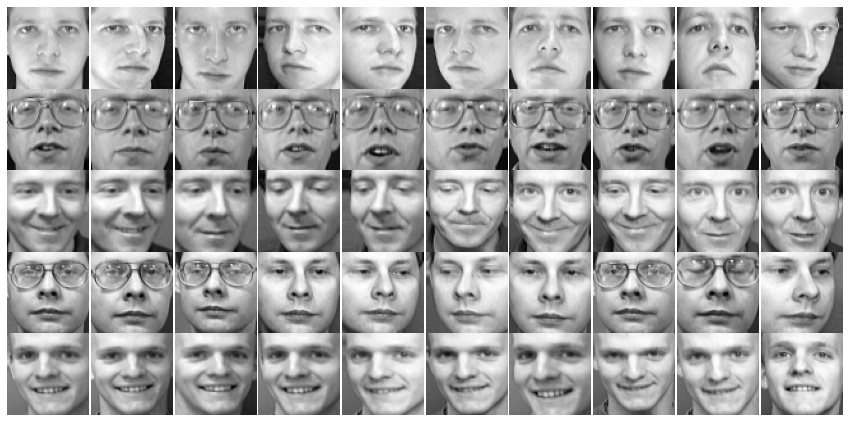

In [7]:
display_faces(allFaces, range(5))

Теперь для того, чтобы вывести любую из 400 фотографий, нужно обратиться к соответствующему столбцу матрицы `allFaces` и заново сформировать из столбца матрицу 64 на 64.

In [8]:
def display_face(Face):
    seaborn.set_style('white')
    plt.figure(figsize=(3,3))
    plt.imshow(Face.reshape(fW,fH), cmap='gray')
    plt.axis('off')
    plt.show()

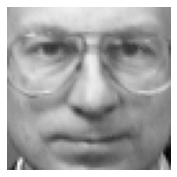

In [9]:
display_face(allFaces[:,121])

In [10]:
def display_face_i(Faces, i):
    display_face(Faces[:,i])

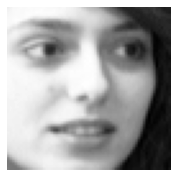

In [11]:
# access to photo
display_face_i(allFaces, 73)

### Обучающая выборка

Убираем последнюю персону.

In [12]:
trainFaces = allFaces[:,:-10]

Смотрим на два последних.
Было:

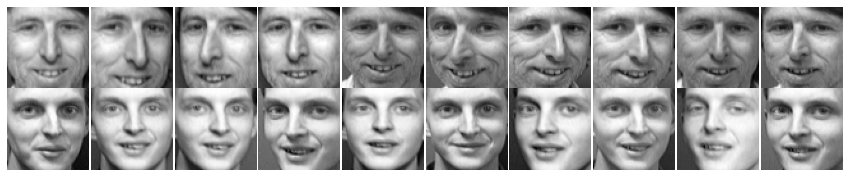

In [13]:
display_faces(allFaces, [-2, -1])

Стало:

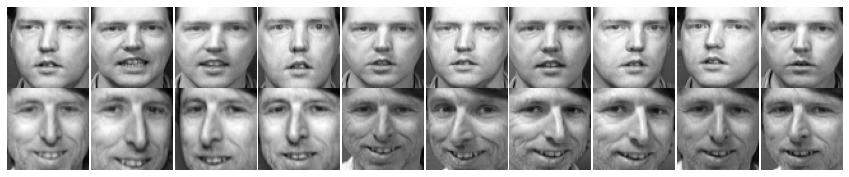

In [14]:
display_faces(trainFaces, [-2, -1])

---

## Главные компоненты

Сделаем сингулярное разложение матрицы с обучающей выборкой. Получим 390 главных компонент.

In [15]:
# Singular value decomposition
U, s, Vt = LA.svd(trainFaces, full_matrices=False)
Sigma = np.diag(s)
print(f'Quantity of PC = {len(s)}')

Quantity of PC = 390


Посмотрим на первые 8 главных компонент.

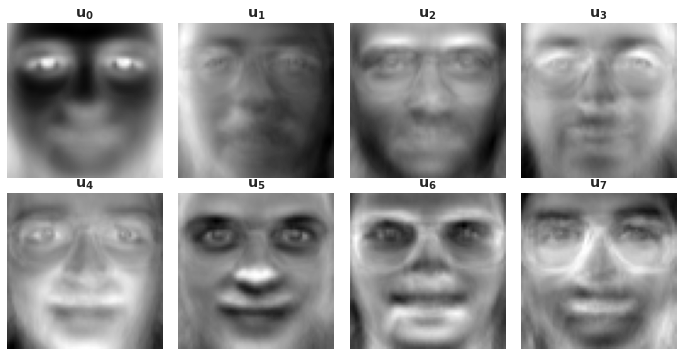

In [16]:
size = 3
fig, axes = plt.subplots(2, 4, figsize=(4*size, 2*size))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(8):
    axes[i//4, i%4].imshow(U[:,i].reshape(fW,fH), cmap='gray')
    axes[i//4, i%4].set_title(f'$\mathbf{{u_{i}}}$')
    axes[i//4, i%4].axis('off')
plt.show()

Теперь поиграем с данными.
Попытаемся восстановить конкретную фотографию по её главным компонентам.
Интересно сравнить фотографии 60 и 64, они отличаются, в основном, очками.

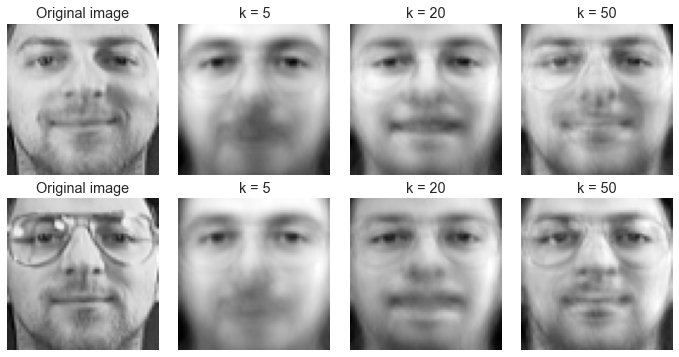

In [17]:
i_imgs = [60, 64]
k_list = [5, 20, 50]
size = 3
fig, axes = plt.subplots(1*len(i_imgs), 4, figsize=(4*size, len(i_imgs)*size))

# fig.suptitle("Reconstructed image using the first k singular values")
plt.subplots_adjust(wspace=0.1, hspace=0.15)
for j, i_img in enumerate(i_imgs):

    axes[j, 0].imshow(Imgs[i_img], cmap='gray')
    axes[j, 0].set_title("Original image")
    axes[j, 0].axis('off')
    for i, k in enumerate(k_list):
        # Reconstruction of the matrix using the first k singular values
        i += 1
        reconFace = U[:, :k] @ Sigma[:k, :k] @ Vt[:k, i_img]
        axes[j + i//4, i%4].imshow(reconFace.reshape(fW,fH), cmap='gray')
        axes[j + i//4, i%4].set_title("k = {}".format(k))
        axes[j + i//4, i%4].axis('off')
plt.show()
# fig.tight_layout()
# fig.savefig('1.png')

Сравним аппроксимации 4 первых фотографий, сделанные по $k$ главным компонентам, с оригиналами.

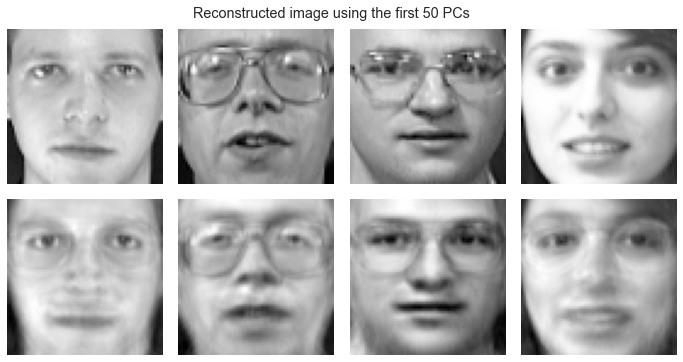

In [18]:
k = 50
i_img = [0, 10, 50, 70]

size=3
fig, axes = plt.subplots(2, 4, figsize=(4*size, 2*size))
fig.suptitle(f'Reconstructed image using the first {k} PCs', y=0.93)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, img in enumerate(i_img):
    reconFace = U[:, :k] @ Sigma[:k, :k] @ Vt[:k, img]
    axes[0, i].imshow(Imgs[img], cmap='gray')
    axes[1, i].imshow(reconFace.reshape(fW,fH), cmap='gray')

[axis.axis('off') for axis in axes.flatten()]
plt.show()

---

## Коэффициенты

Посмотрим взаимное расположение "проекций лиц" (коэффициенты в разложении какого-либо ракурса по компонентам) на i и j главные компоненты.
Это показывает тенденции в данных.

In [19]:
p = 16
Vt[[6,7]][:,p*10:(p+1)*10]

array([[ 0.02937775,  0.01680991,  0.03970261, -0.0014609 ,  0.02107309,
        -0.00051833, -0.01543625,  0.0522579 ,  0.01868202, -0.04142922],
       [-0.0078598 , -0.0056702 ,  0.07384474,  0.06658413, -0.00209898,
         0.04947078,  0.04176423,  0.00416772,  0.04765222,  0.04981159]],
      dtype=float32)

In [20]:
def plot_pc_coeff(Vt, ps_idx, pc_idx):
    # PC coefficients
    seaborn.set_style('whitegrid')
    plt.figure(figsize=(7, 7))
    
    for p in ps_idx:
        pc = Vt[pc_idx][:,p*10:(p+1)*10]
        plt.plot(*pc, 'o', label=f'Pers. {p}')
    plt.xlabel(f'PC{pc_idx[0]}')
    plt.ylabel(f'PC{pc_idx[1]}')
    plt.legend(loc=0)
    plt.show()

In [21]:
# different persons
ps_idx = [5, 7]
pc_idx = [0, 1]

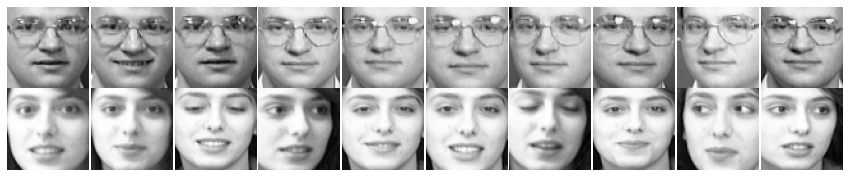

In [22]:
display_faces(trainFaces, ps_idx)

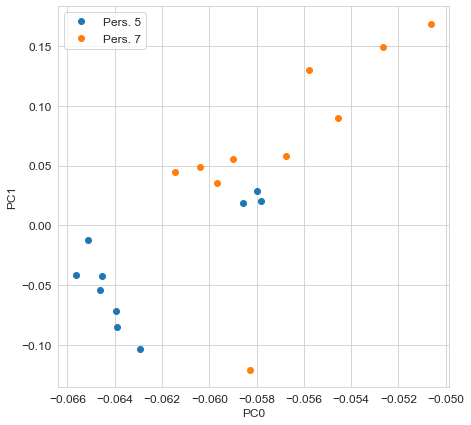

In [23]:
# pca trends
plot_pc_coeff(Vt, ps_idx, pc_idx)

---

# Аппроксимация

In [24]:
def PC_recon(U, k, testFace):
    F = U[:, :k]
    Face = F @ F.T @ testFace
    return Face

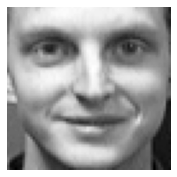

In [25]:
testFace = allFaces[:, -5]
display_face(testFace)

In [26]:
k = 100
reconFace = PC_recon(U, k, testFace)
# display_face(reconFace)

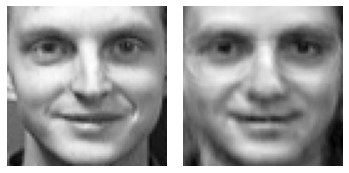

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(2*size, size))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

axes[0].imshow(testFace.reshape(fW,fH), cmap='gray')
axes[1].imshow(reconFace.reshape(fW,fH), cmap='gray')
[axis.axis('off') for axis in axes.flatten()]
plt.show()

Испортим фотографию

In [28]:
rng = np.random.default_rng(seed=42)
mask = np.ones_like(testFace)
n_bad = int(0.5 * fW*fH)
idx_bad = rng.choice(fW*fH, n_bad, replace=False)
mask[idx_bad] = 0

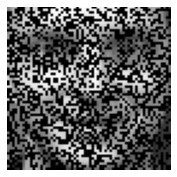

In [29]:
badFace = mask * testFace.copy()
display_face(badFace)

In [30]:
k = 50
U_mask = mask.reshape(-1,1) * U.copy()
Alpha = U_mask[:, :k].T @ badFace
reconBadFace = U[:, :k] @ Alpha
# display_face(Face)

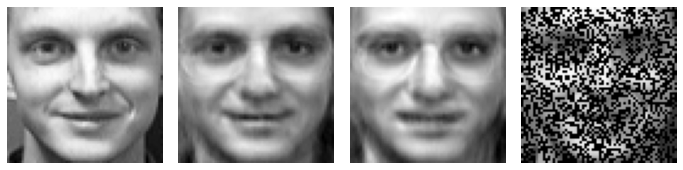

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(4*size, size))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

axes[0].imshow(testFace.reshape(fW,fH), cmap='gray')
axes[1].imshow(reconFace.reshape(fW,fH), cmap='gray')
axes[2].imshow(reconBadFace.reshape(fW,fH), cmap='gray')
axes[3].imshow(badFace.reshape(fW,fH), cmap='gray')
[axis.axis('off') for axis in axes.flatten()]
plt.show()

---

In [32]:
# from PIL import Image
# img = Image.open("pix/Eigenfaces/Einstein_3.png").convert('L')
# img.save('pix/Eigenfaces/Einstein.png')

In [33]:
# Reading the image
img = plt.imread("pix/Eigenfaces/Einstein.png")
print(np.shape(img))

(64, 64)


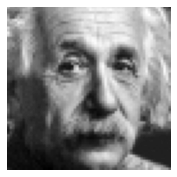

In [34]:
testFace = img.flatten()
display_face(testFace)

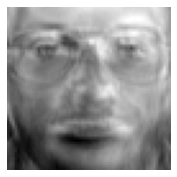

In [35]:
k = 50
Face = PC_recon(U, k, testFace)
display_face(Face)

---

In [36]:
# Versions used
import sys
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(seaborn.__version__))

Python: 3.7.11
numpy: 1.20.3
matplotlib: 3.5.1
seaborn: 0.11.2
